# Датасет "пост: комментарии" VK Лентач

In [1]:
import requests
import re
from tqdm.notebook import tqdm
import pickle

In [2]:
def get_group_id():
    url_formatted = group_info.format(access_token = access_token, group_id=domain, api_version = api_version)
    res_wall = requests.get(url_formatted)
    return res_wall.json()['response'][0]['id']

In [3]:
access_token = 'YOUR_TOKEN'
api_version = '5.89'
domain = 'lentach'

In [47]:
url = 'https://api.vk.com/method/wall.get?domain={domain}&count=100&offset={offset}&access_token={access_token}&v={api_version}'
comment_url = 'https://api.vk.com/method/wall.getComments?owner_id={owner_id}&post_id={post_id}&count=100&offset={offset}&access_token={access_token}&v={api_version}'
group_info = 'https://api.vk.com/method/groups.getById?group_id={group_id}&access_token={access_token}&v={api_version}'

In [48]:
group_id = get_group_id()

In [129]:
digits = set('0123456789')
foreign = set('ýčäәҗңһöミ音ク初åöї羊文学フイスロクェ@') # █

def get_prepared_text(text, lower_bound=5):
    if len(set(text) & digits) != 0:
        return None
    
    text = text.lower()
    
    if len(foreign & set(text)):
        #print(text)
        return None
    
    text = re.sub(r'http.*', ' ', text) # ссылки
    text = re.sub(r'\[id.*\]', ' ', text) # упоминания
    text = re.sub(r'\#радиолентач', ' радиолентач ', text)
    text = re.sub(r'\#\w+', ' ', text) # хештеги
    text = re.sub(r'—', r'-', text) 
    text = re.sub(r'–', r'-', text)
    text = re.sub(r'‑', r'-', text)
    
    text = re.sub(r'…', r'...', text)
    
    text = re.sub(r'„', r'"', text)
    text = re.sub(r'«', r'"', text)
    text = re.sub(r'“', r'"', text)
    text = re.sub(r'”', r'"', text)
    text = re.sub(r'»', r'"', text)
    text = re.sub(r'’', r'', text)
    text = re.sub(r'`', r'', text)
    text = re.sub(r'\'', r'', text)
    text = re.sub(r'і', r'i', text)  
    text = re.sub(r'í', r'i', text) 
    text = re.sub(r'é', r'e', text)  
    text = re.sub(r'è', r'e', text) 
    text = re.sub(r'π', r' пи ', text)
    text = re.sub(r'<...>', ' ', text)

    
    access = r'[^a-zа-яё\s\.\!\?&,-:\(\);""]+'
    
    text = re.sub( access, ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    if 'comment deleted by user or page manager' in text:
        return None
    
    if len(text.split()) >= lower_bound:
        return text

In [130]:
texts = []
post_ids = []
post_comments = []
n_posts = 20000
for i in tqdm(range(43, n_posts, 100)):
    url_formatted = url.format(access_token = access_token, domain=domain, api_version = api_version, offset = i)
    res_wall = requests.get(url_formatted)
    for post in res_wall.json()["response"]['items']:
        text = get_prepared_text(post["text"])
        if text:
            texts.append(text)
            post_ids.append(post['id'])

In [131]:
text_and_comments = []

In [150]:
import gzip
import json
import codecs

from multiprocessing.dummy import Pool, Queue

queue = Queue()

In [151]:
results = [[] for i in range(4)]

In [152]:
for i in range(len(post_ids)):
    queue.put(i)

In [153]:
lower_bound_comments = 10

In [154]:
def process_wrapper(i):
    while not queue.empty():
        num = queue.get()
        post_id, post_text = post_ids[num], texts[num]
        
        comment_formatted = comment_url.format(owner_id=-group_id, access_token=access_token, post_id=post_id,
                                           api_version = api_version, offset = 0)
        res_comment = requests.get(comment_formatted)
        comments = []
        for comment in res_comment.json()["response"]['items']:
            text = get_prepared_text(comment['text'])
            if text:
                comments.append(text)
        
        if len(comments) >= lower_bound_comments:
            results[i % 4].append( (post_text, comments) ) 

        with lock:
            pbar.update(1)

In [155]:
with Pool(processes=4) as pool, tqdm(total=queue.qsize()) as pbar:
    lock = pbar.get_lock()
    pool.map(process_wrapper, range(pool._processes))

pool.join()

ConnectionError: HTTPSConnectionPool(host='api.vk.com', port=443): Max retries exceeded with url: /method/wall.getComments?owner_id=-29534144&post_id=14000569&count=100&offset=0&access_token=d4a10380d4a10380d4a1038012d4d6f157dd4a1d4a10380b409e65e21a08c6735cd447f&v=5.89 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7febdb3d7c70>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [156]:
text_and_comments = results[0] + results[1] + results[2] + results[3]

In [157]:
len(text_and_comments)

5880

In [160]:
text_and_comments[10]

('zoloto - казахстанский поп-исполнитель и основатель рок-группы cardio beat, обладающий завораживающим голосом. традиционный радиолентач',
 ['казахстан угрожает нам бомбарди ладно.',
  'чет такой себе, заурядный голосок',
  'не похож на казаха однако',
  'hfp ldf nhb xtnsht gznm',
  'после прослушивания пары композиций кровь из ушей не пошла, значит достойно',
  'на пушкина похож у толстого какой ? - толстый ... у пушкина какой - кудрявый , у горького какой ?',
  'любимый исполнитель уже несколько лет',
  'так, я просто оставлю роцк из новой школы с действительно завораживающим голосом',
  'ну музыкальные подборки это конечно далеко не первый конёк лентача... зато гениальность пикчеров все компенсирует :)',
  'сочувствую тебе немного в этом диалоге даже.',
  'какой-то у него педорковатый видок типичного псевдоинтеллигента из ssаного пидера.',
  'любимый иcпoлнитeль ужe нecкoлькo лeт',
  'включила первую песню, помотала на середину, "теперь моя первая телка моя вторая телка", выключила

In [163]:
with open('vk_5880.pickle', 'wb') as handle:
    pickle.dump(text_and_comments, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [168]:
with open('vk_2500.pickle', 'wb') as handle:
    pickle.dump(text_and_comments[:2500], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Забыли про завершение предложения

In [266]:
vk_comments_comma = []

In [267]:
cont = set(':,;')
dots = set('.!?()')

def upd(s):
    if s[-1] in cont:
        s = ''.join( (s[:-1], '.') )
    elif s[-1] not in dots:
        s = ''.join( (s, '.') )
    return s


for pst, comm in tqdm(text_and_comments):
    pst = upd(pst)
    new_comments = []
    for cm in comm:
        new_comments.append( upd(cm) )
    vk_comments_comma.append( (pst, new_comments) )

In [269]:
with open('vk_5880_comma.pickle', 'wb') as handle:
    pickle.dump(vk_comments_comma, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Статистики

In [179]:
post_lens = [len(post) for post, _ in text_and_comments]

In [181]:
all_comments_len = [len(comm) for _, comments in text_and_comments for comm in comments ]

In [182]:
group_comments_len = []
for _, comments in text_and_comments:
    t = []
    for comm in comments:
        t.append(len(comm))
    group_comments_len.append( np.mean(t) )

In [184]:
import matplotlib.pyplot as plt

(array([8.520e+02, 1.482e+03, 1.138e+03, 1.161e+03, 6.710e+02, 2.550e+02,
        1.060e+02, 5.900e+01, 4.700e+01, 3.200e+01, 3.100e+01, 1.200e+01,
        7.000e+00, 1.000e+01, 6.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([  20.  ,   80.08,  140.16,  200.24,  260.32,  320.4 ,  380.48,
         440.56,  500.64,  560.72,  620.8 ,  680.88,  740.96,  801.04,
         861.12,  921.2 ,  981.28, 1041.36, 1101.44, 1161.52, 1221.6 ,
        1281.68, 1341.76, 1401.84, 1461.92, 1522.  ]),
 <BarContainer object of 25 artists>)

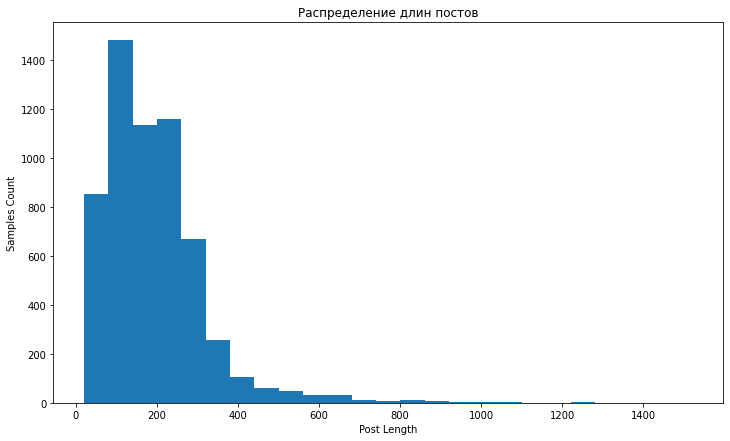

In [211]:
plt.figure(figsize=(12,7))
plt.xlabel('Post Length')
plt.ylabel('Samples Count')
plt.title('Распределение длин постов')
plt.hist(post_lens, bins=25)

(array([ 1280., 67809., 59972., 34488., 21028., 13254.,  8905.,  5925.,
         4267.,  3157.,  2293.,  1802.,  1380.,  1174.,   873.,   704.,
          559.,   454.,   362.,   334.,   289.,   271.,   232.,   157.,
          146.,   129.,   102.,    91.,    91.,    81.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
        220., 240., 260., 280., 300., 320., 340., 360., 380., 400., 420.,
        440., 460., 480., 500., 520., 540., 560., 580., 600.]),
 <BarContainer object of 30 artists>)

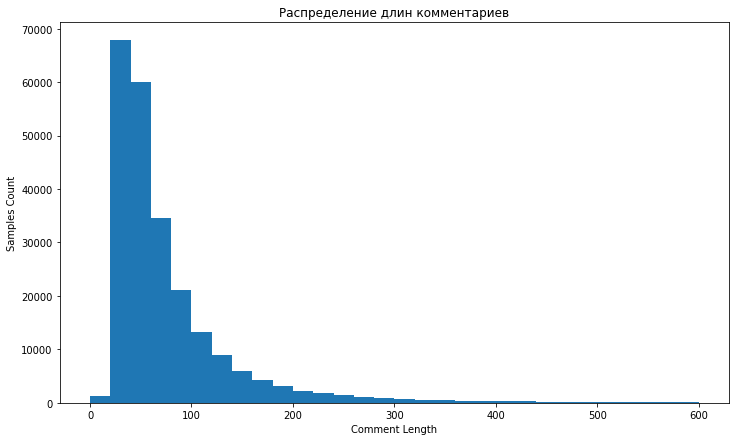

In [212]:
plt.figure(figsize=(12,7))
plt.xlabel('Comment Length')
plt.ylabel('Samples Count')
plt.title('Распределение длин комментариев')
plt.hist(all_comments_len, bins=30, range=(0, 600))

(array([0.000e+00, 2.700e+01, 1.129e+03, 2.312e+03, 1.504e+03, 5.940e+02,
        2.020e+02, 6.000e+01, 2.900e+01, 1.000e+01, 3.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
        220., 240., 260., 280., 300., 320., 340., 360., 380., 400., 420.,
        440., 460., 480., 500., 520., 540., 560., 580., 600.]),
 <BarContainer object of 30 artists>)

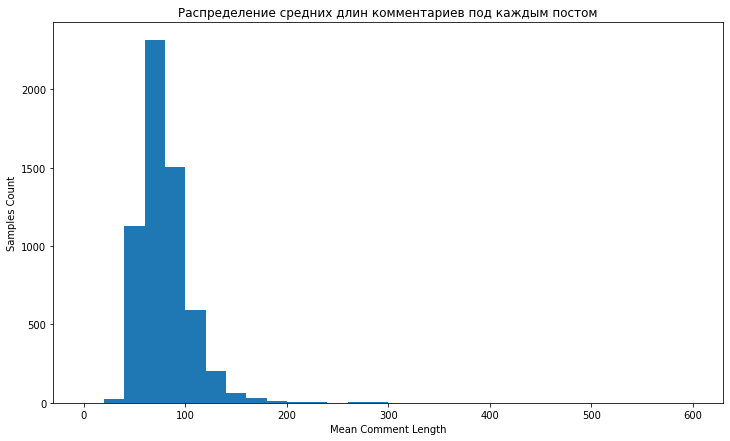

In [213]:
plt.figure(figsize=(12,7))
plt.xlabel('Mean Comment Length')
plt.ylabel('Samples Count')
plt.title('Распределение средних длин комментариев под каждым постом')
plt.hist(group_comments_len, bins=30, range=(0, 600))